# Lesson 5: Bayesian Regression

## Intro to Quantified Cognition

## Lesson plan

- Extension of BEST
- Introduce Bayesian regression
- Example with simulated data
- Robust regression
- Introduce hierarchical models
- Hierarchical example
- Real-world data analysis in teams


In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import pymc3 as pm

import dists

/home/per/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Independent BEST

Let's extend the example to independent samples!!!


Ttest_indResult(statistic=-1.0847957022849026, pvalue=0.29091597181645185)

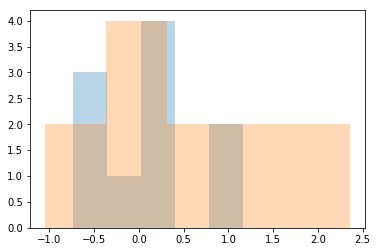

In [2]:
# generate some data that may or may not be significantly different from each other
A = dists.normal(mean=0.2, std=0.5).rvs(10)
B = dists.normal(mean=0.4, std=1.0).rvs(12)

# plot it
plt.hist(A, bins='auto', alpha=0.3);
plt.hist(B, bins='auto', alpha=0.3);

# do a quick t-test
stats.ttest_ind(A, B)

In [4]:
# first get overall mean and std
overall_mean = np.append(A, B).mean()
overall_std = np.append(A, B).std()
print('overall_mean:', overall_mean)
print('ovearll_std:', overall_std)

overall_mean: 0.35601447877827685
ovearll_std: 0.9027047458605629


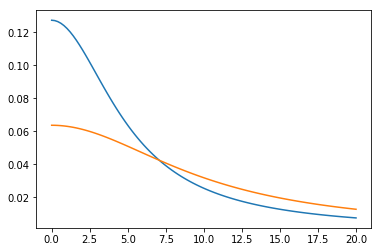

In [6]:
x = np.linspace(0, 20, 100)
plt.plot(x, dists.halfcauchy(scale=5).pdf(x))

plt.plot(x, dists.halfcauchy(scale=10).pdf(x))

In [16]:
# define a model
with pm.Model() as model:
    # set up the params/priors
    mu_A = pm.Normal('mu_A', overall_mean, overall_std*2.0)
    sd_A = pm.HalfCauchy('sd_A', 5)
    
    mu_B = pm.Normal('mu_B', overall_mean, overall_std*2.0)
    sd_B = pm.HalfCauchy('sd_B', 5)
    
    
    nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    
    # build the model
    #lam = data_std**-2.
    data_A = pm.StudentT('data_A', mu=mu_A, sd=sd_A, nu=nu, observed=A)
    data_B = pm.StudentT('data_B', mu=mu_B, sd=sd_B, nu=nu, observed=B)
    
    # set up some deterministic vars to keep
    diff_of_means = pm.Deterministic('difference of means', mu_A - mu_B)
    diff_of_stds = pm.Deterministic('difference of stds', sd_A - sd_B)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((sd_A**2 + sd_B**2) / 2))

    

In [17]:
model

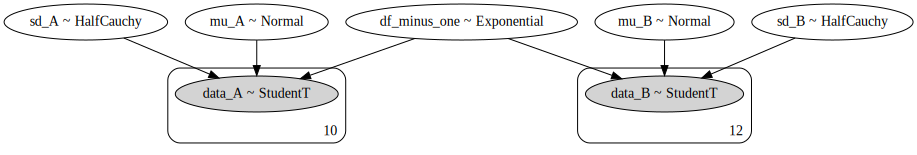

In [18]:
pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [df_minus_one, sd_B, mu_B, sd_A, mu_A]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 986.82draws/s] 


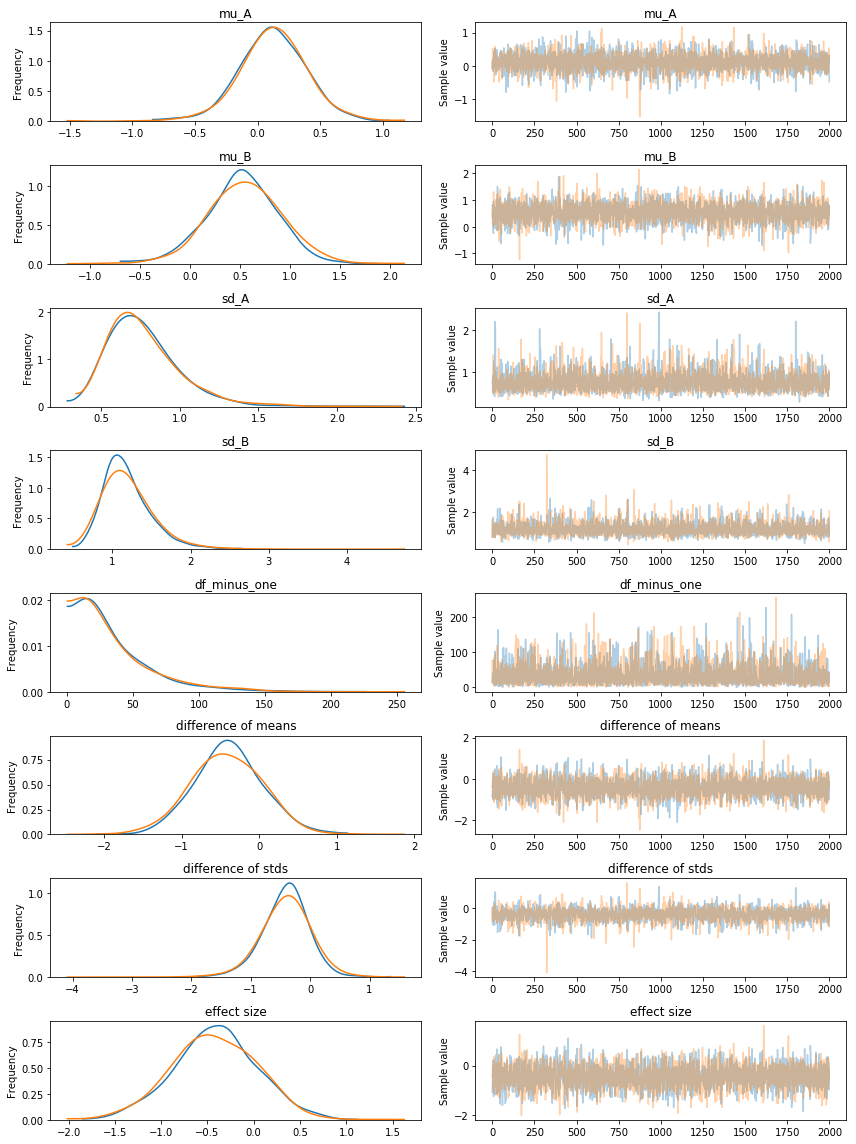

In [11]:
pm.traceplot(trace);

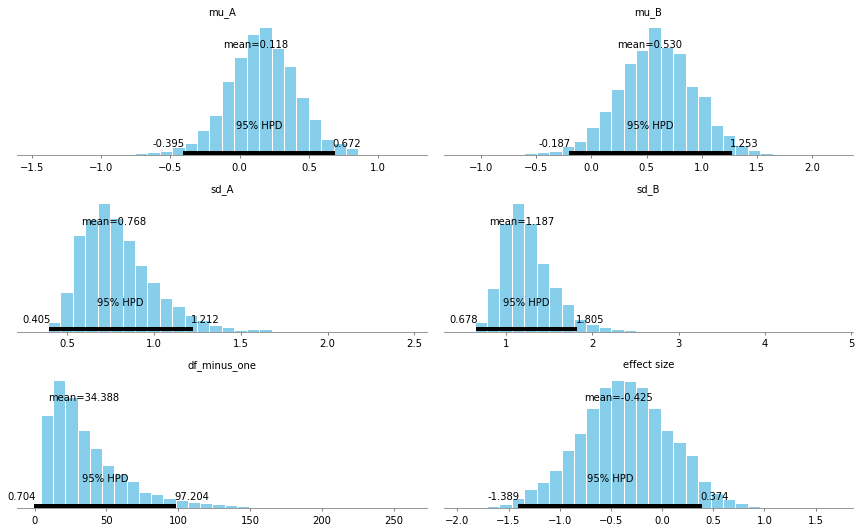

In [12]:
pm.plot_posterior(trace, varnames=['mu_A', 'mu_B', 'sd_A', 'sd_B', 'df_minus_one', 'effect size']);

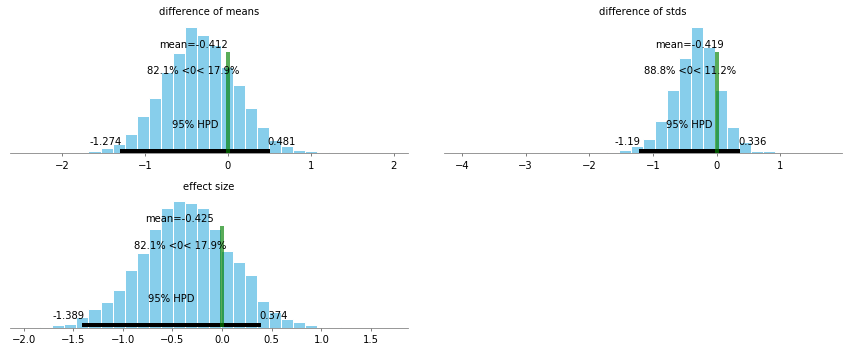

In [13]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0.0);


## Linear Regression

One of the most common and flexible statistical approaches.

Involves building a model that can predict the dependent data ($y$) based on different combinations of independent data ($x$):

$$y = \beta_0 + \beta_1 x + \epsilon$$


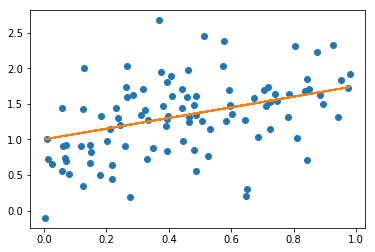

In [41]:
# generate some data with a linear trend
nsamples = 100
true_slope = 0.75
true_intercept = 1.0
true_sigma = 0.5

# uniform sampling over x
x = dists.uniform(0, 1).rvs(nsamples)

# apply noise to linear model
y_true = true_intercept + true_slope*x 
y = y_true + dists.normal(mean=0.0, std=true_sigma).rvs(nsamples)

# set the data
data = pd.DataFrame(dict(x=x, y=y))

# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_true, '-')

In [42]:
data.head()

,x,y
0,0.457935,1.592700
1,0.850301,1.705048
2,0.004637,-0.103795
3,0.202942,0.981910
4,0.511759,2.448279


In [43]:
# define a standard linear model
with pm.Model() as model:
    # set up the params/priors
    intercept = pm.Normal('intercept', 0, 20)
    slope = pm.Normal('slope', 0, 20)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # combine them into a linear function for the likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x, 
                           sd=sigma, observed=y)
    

In [24]:
# sample the posterior
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1517.27draws/s]


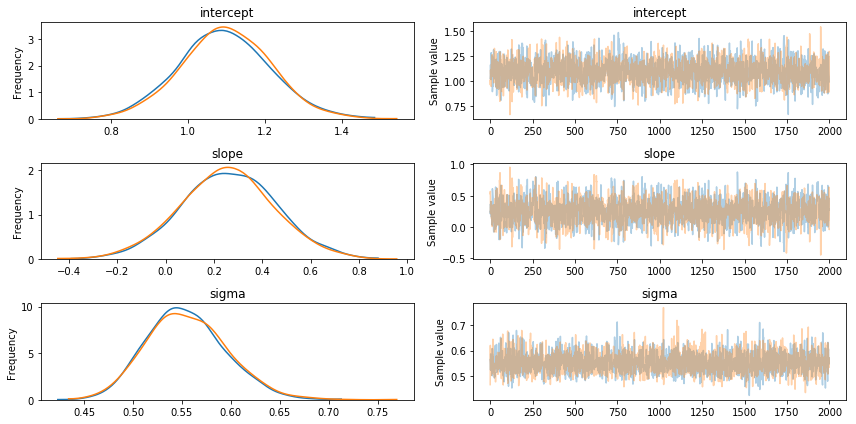

In [26]:
pm.traceplot(trace);

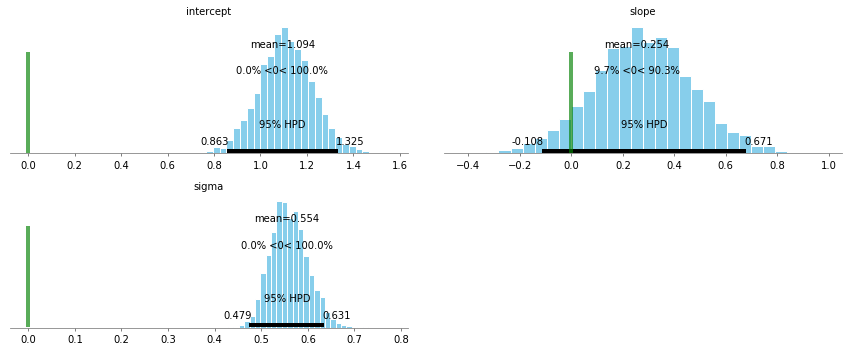

In [27]:
pm.plot_posterior(trace, varnames=['intercept', 'slope', 'sigma'],
                  ref_val=0.0);

## Dealing with outliers

Sometimes data can be messy. You can either assume every observation affects the statistical inference similarly, or you can try and downplay the effect of potential outliers.

This approach is also known as robust regression.


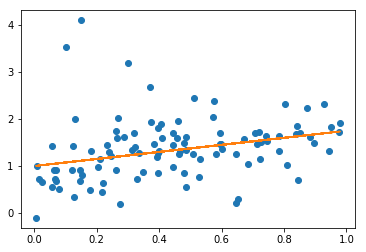

In [44]:
# let's add in some outliers!
x_out = np.append(x, [.1, .15, .3])
y_out = np.append(y, [3.54, 4.1, 3.2])

# plot the data
plt.plot(x_out, y_out, 'o')
plt.plot(x, y_true, '-')

In [45]:
# define a linear model with Gaussian noise
with pm.Model() as model:
    # set up the params/priors
    intercept = pm.Normal('intercept', 0, 20)
    slope = pm.Normal('slope', 0, 20)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # combine them into a linear function for the likelihood
    likelihood = pm.Normal('y_out', mu=intercept + slope * x_out, 
                           sd=sigma, observed=y_out)
    

In [46]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1601.67draws/s]
The acceptance probability does not match the target. It is 0.8806010300834213, but should be close to 0.8. Try to increase the number of tuning steps.


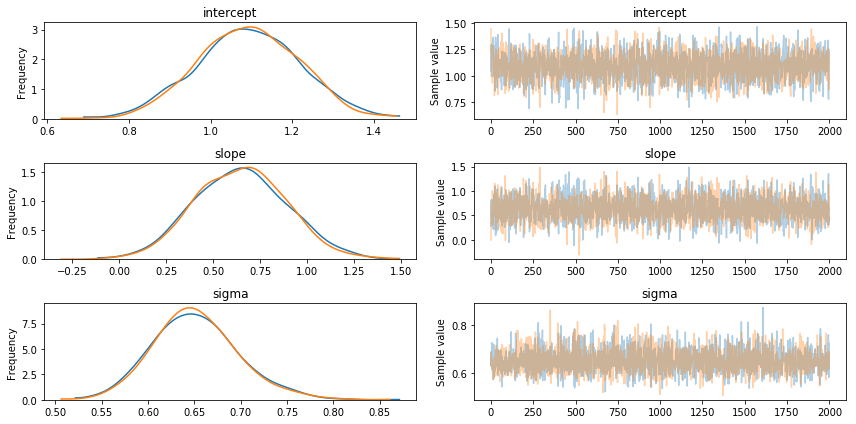

In [47]:
pm.traceplot(trace);

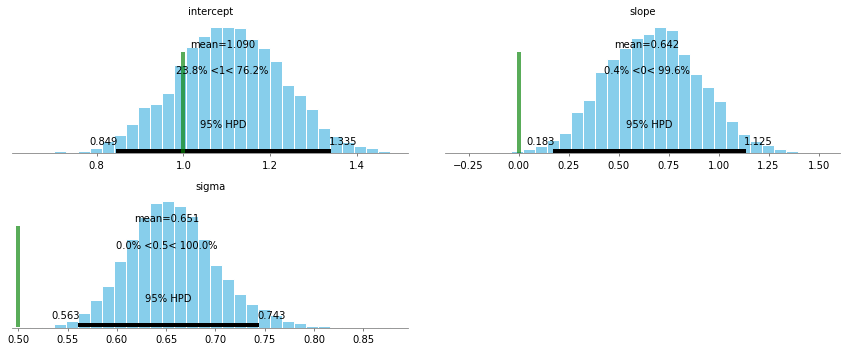

In [48]:
pm.plot_posterior(trace, varnames=['intercept', 'slope', 'sigma'],
                  ref_val=[true_intercept, 0.0, true_sigma]);

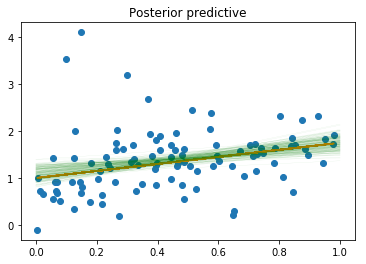

In [49]:
# let's check with the posterior predictives
lm = lambda x, samples: samples['intercept'] + x*samples['slope']

# plot the data
plt.plot(x_out, y_out, 'o')
plt.plot(x, y_true, '-')

pm.plot_posterior_predictive_glm(trace, eval=np.linspace(0, 1, 100), 
                                 lm=lm, samples=200, color="green", alpha=.15)

In [50]:
# Can we fix it?
# define a model
with pm.Model() as model:
    # set up the params/priors
    intercept = pm.Normal('intercept', 0, 20)
    slope = pm.Normal('slope', 0, 20)
    sigma = pm.HalfCauchy('sigma', 10)
    nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    
    # combine them into a robust linear function for the likelihood
    likelihood = pm.StudentT('y_out', mu=intercept + slope * x_out, 
                             sd=sigma, nu=nu, observed=y_out)
    

In [51]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [df_minus_one, sigma, slope, intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1191.22draws/s]


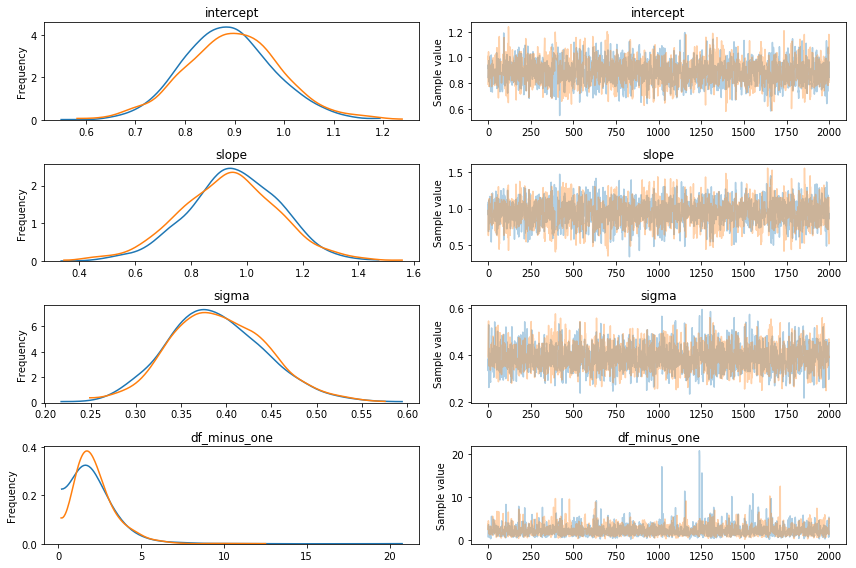

In [52]:
pm.traceplot(trace);

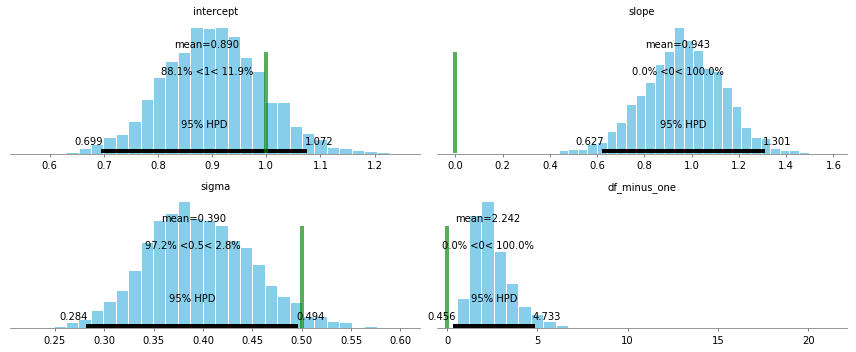

In [53]:
pm.plot_posterior(trace, varnames=['intercept', 'slope', 'sigma', 'df_minus_one'],
                  ref_val=[true_intercept, 0.0, true_sigma, 0.0]);

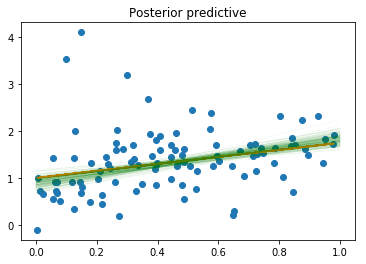

In [54]:
# let's check with the posterior predictives
lm = lambda x, samples: samples['intercept'] + x*samples['slope']

# plot the data
plt.plot(x_out, y_out, 'o')
plt.plot(x, y_true, '-')

pm.plot_posterior_predictive_glm(trace, eval=np.linspace(0, 1, 100), 
                                 lm=lm, samples=200, color="green", alpha=.15)

## Hierarchical Regression

What should we do when we have multiple groups/subjects?

Ideally we should share information across groups to inform the models fit to the individuals.

This is called multi-level or hierarchical modeling.

In [95]:
# load some data
dat = pd.read_csv('data/flanker_dat.csv')

# remove nans
dat = dat[~np.isnan(dat['rt'])]

dat.head()

,appear_time_time,condition,corr_resp,correct,datetime,loc_x,loc_y,log_time,press_time_error,press_time_time,pressed,rt,run_num,stim,subj
0,1787.897096,~,F,True,20180917_131349,6.123234e-17,1.000000,1788.663548,0.000487,1788.663548,F,0.766451,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101
1,1789.522516,~,J,True,20180917_131349,7.071068e-01,-0.707107,1790.983430,0.000479,1790.983430,J,1.460914,0,__>__\n_><>_\n><><>\n_><>_\n__>__\n,101
2,1791.939483,~,F,True,20180917_131349,-1.836970e-16,-1.000000,1792.928294,0.000980,1792.928294,F,0.988812,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101
3,1793.739963,=,J,True,20180917_131349,1.000000e+00,0.000000,1794.552259,0.000489,1794.552259,J,0.812296,0,__<__\n_<><_\n<>>><\n_<><_\n__<__\n,101
4,1795.340368,~,F,True,20180917_131349,-7.071068e-01,-0.707107,1796.055466,0.000478,1796.055466,F,0.715098,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101


In [96]:
# usually best to look at log rt
dat['log_rt'] = np.log(dat['rt'])

# make a numeric index of subject 
# (only works b/c these subj ids start at 101 and are contiguous)
dat['subj_idx'] = dat['subj']-101
dat.columns

Index(['appear_time_time', 'condition', 'corr_resp', 'correct', 'datetime',
       'loc_x', 'loc_y', 'log_time', 'press_time_error', 'press_time_time',
       'pressed', 'rt', 'run_num', 'stim', 'subj', 'log_rt', 'subj_idx'],
      dtype='object')

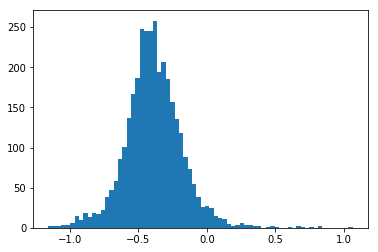

In [97]:
# show how distribution of log_rts is mostly normal
plt.hist(dat['log_rt'].values, bins='auto');

In [98]:
# show overall means for each condition
dat.groupby(['condition'])['log_rt'].mean()

condition
+   -0.467363
=   -0.379976
~   -0.322216
Name: log_rt, dtype: float64

In [99]:
# make a numerical condition variable
dat['num_cond'] = 0
dat.loc[dat['condition']=='=', 'num_cond'] = 1
dat.loc[dat['condition']=='~', 'num_cond'] = 2
dat.num_cond.unique()

array([2, 1, 0])

In [101]:
# get various ways to index the data
subj_idx = dat.subj_idx.values
n_subj = len(dat.subj.unique())


In [102]:
print('Overall mean:', dat.log_rt.mean())
print('Overall std:', dat.log_rt.std())

Overall mean: -0.38980821568002116
Overall std: 0.21076148021266058


In [103]:
# define the hierarchical model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_inter = pm.Normal('mu_inter', mu=dat.log_rt.mean(), sd=dat.log_rt.std()*10)
    sigma_inter = pm.HalfCauchy('sigma_inter', 10)
    mu_slope = pm.Normal('mu_slope', mu=0., sd=dat.log_rt.std()*10)
    sigma_slope = pm.HalfCauchy('sigma_slope', 10)

    # Intercept for each subj, distributed around group mean
    intercept = pm.Normal('intercept', mu=mu_inter, sd=sigma_inter, shape=n_subj)
    # slope for each subj, distributed around group mean
    slope = pm.Normal('slope', mu=mu_slope, sd=sigma_slope, shape=n_subj)

    # Model error
    eps = pm.HalfCauchy('eps', 10)

    log_rt_est = intercept[subj_idx] + slope[subj_idx] * dat.num_cond.values

    # Data likelihood
    log_rt_like = pm.Normal('log_rt_like', mu=log_rt_est, sd=eps, observed=dat.log_rt)

In [104]:
with hierarchical_model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, slope, intercept, sigma_slope, mu_slope, sigma_inter, mu_inter]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:13<00:00, 369.66draws/s]


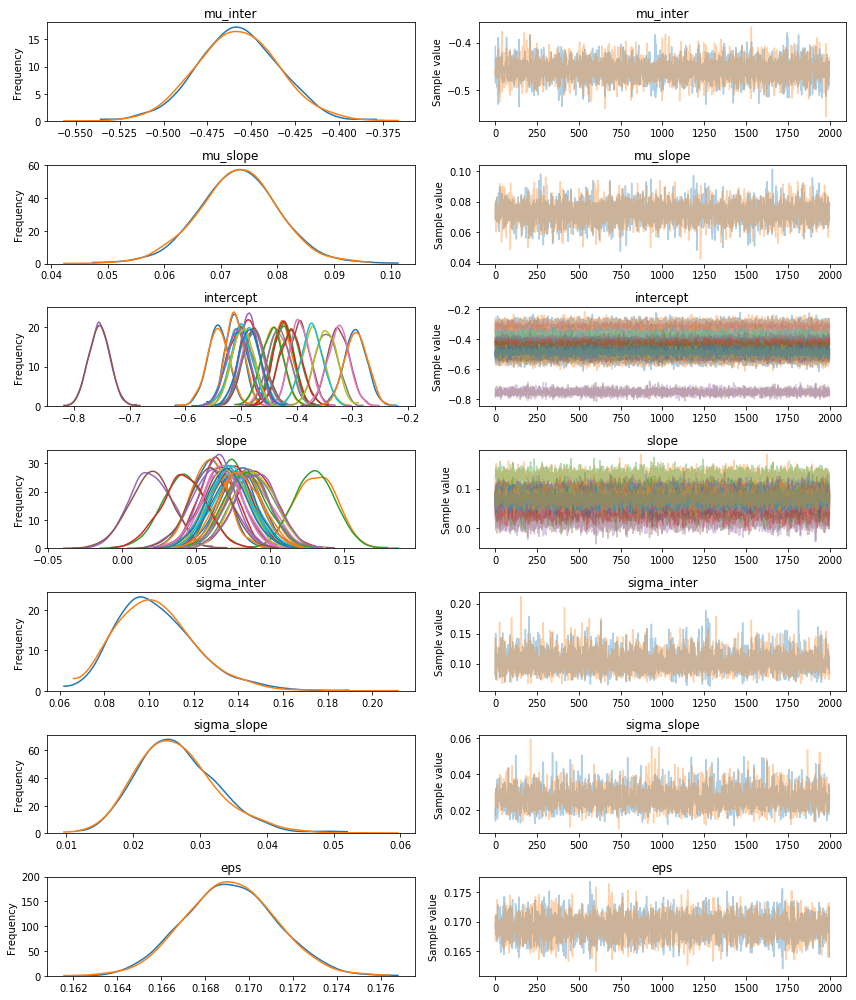

In [105]:
pm.traceplot(trace);

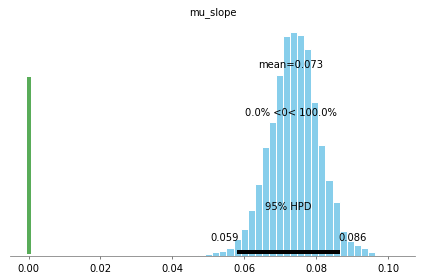

In [106]:
pm.plot_posterior(trace, varnames=['mu_slope'], ref_val=0.0)